In [31]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import os 

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [33]:
print("using device", device)

using device cuda


In [34]:
class Generator(nn.Module):
    def __init__(self, class_num, noise_dim=100):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.label_emb = nn.Embedding(class_num, class_num)
        self.net = nn.Sequential(
            nn.Linear(noise_dim + class_num, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        z = z.view(-1, self.noise_dim)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        return self.net(x).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self, class_num):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(class_num, class_num)
        self.net = nn.Sequential(
            nn.Linear(28 * 28 + class_num, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        x = x.view(-1, 28*28)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.net(x)

In [35]:
class_num = 10
generator = Generator(class_num).to(device)
discriminator = Discriminator(class_num).to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

def get_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, device=device)

In [36]:
num_epochs = 30
noise_dim = 100
os.makedirs('mnist_cgan_results', exist_ok=True)
loss_d_list, loss_g_list = [], []

for epoch in range(num_epochs):
    total_loss_d, total_loss_g = 0, 0
    for i, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        labels = labels.to(device)
        
        discriminator.zero_grad()
        outputs = discriminator(images.to(device), labels).view(-1, 1)
        loss_d_real = criterion(outputs, real_labels)
        loss_d_real.backward()
        
        z = get_noise(batch_size, noise_dim)
        fake_images = generator(z, labels)
        outputs = discriminator(fake_images.detach(), labels).view(-1, 1)
        loss_d_fake = criterion(outputs, fake_labels)
        loss_d_fake.backward()
        
        loss_d = loss_d_fake + loss_d_real
        optimizer_d.step()
        
        generator.zero_grad()
        outputs = discriminator(fake_images, labels).view(-1, 1)
        loss_g = criterion(outputs, real_labels)
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item()
        total_loss_g += loss_g.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
    
    total_loss_d /= len(train_loader)
    total_loss_g /= len(train_loader)
    loss_d_list.append(total_loss_d)
    loss_g_list.append(total_loss_g)
        
    fake_images = fake_images.reshape(batch_size, 1, 28, 28)
    if (epoch + 1) % 5 == 0:
        vutils.save_image(fake_images, f'mnist_cgan_results/fake_img_epoch_{epoch+1}.png', normalize=True)
        

Epoch [1/30], Step [100/938], Loss D: 0.0842, Loss G: 4.9145
Epoch [1/30], Step [200/938], Loss D: 1.2994, Loss G: 3.0425
Epoch [1/30], Step [300/938], Loss D: 0.1125, Loss G: 3.8815
Epoch [1/30], Step [400/938], Loss D: 0.7052, Loss G: 1.9870
Epoch [1/30], Step [500/938], Loss D: 1.5307, Loss G: 1.6420
Epoch [1/30], Step [600/938], Loss D: 0.2141, Loss G: 3.7897
Epoch [1/30], Step [700/938], Loss D: 0.7314, Loss G: 1.3716
Epoch [1/30], Step [800/938], Loss D: 1.8379, Loss G: 0.7401
Epoch [1/30], Step [900/938], Loss D: 1.0889, Loss G: 1.3700
Epoch [2/30], Step [100/938], Loss D: 0.4961, Loss G: 2.1815
Epoch [2/30], Step [200/938], Loss D: 0.6199, Loss G: 3.2498
Epoch [2/30], Step [300/938], Loss D: 0.8977, Loss G: 3.8056
Epoch [2/30], Step [400/938], Loss D: 0.5516, Loss G: 2.2571
Epoch [2/30], Step [500/938], Loss D: 1.4248, Loss G: 1.1043
Epoch [2/30], Step [600/938], Loss D: 1.1590, Loss G: 2.4220
Epoch [2/30], Step [700/938], Loss D: 1.9273, Loss G: 1.1683
Epoch [2/30], Step [800/

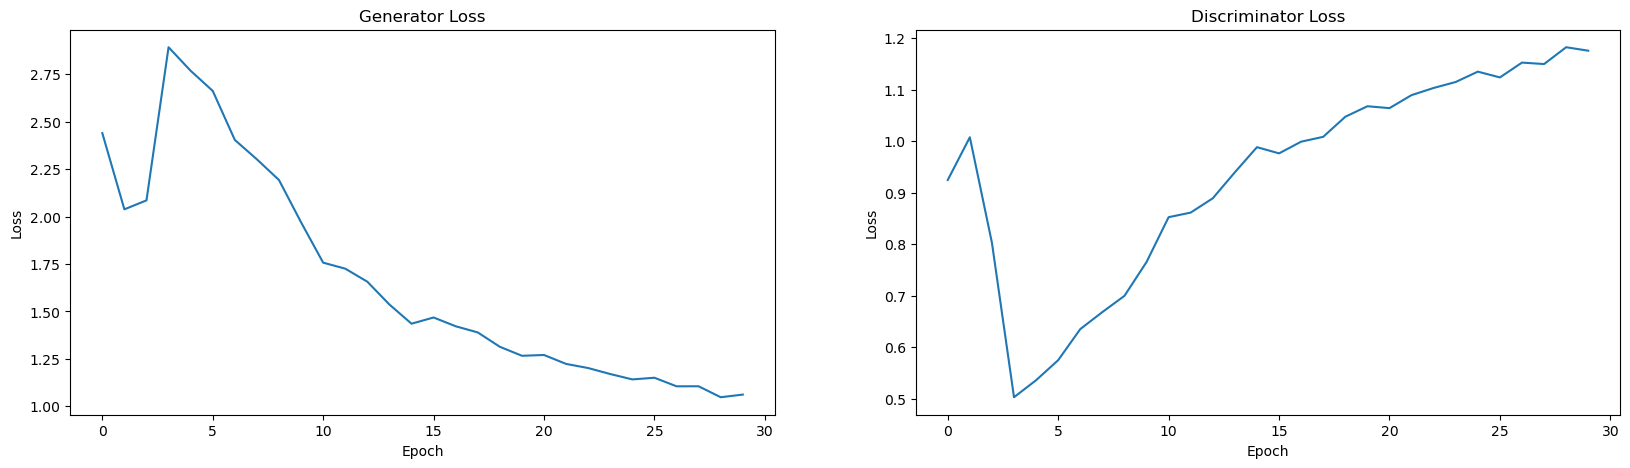

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title('Generator Loss')
axs[0].plot(loss_g_list)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_title('Discriminator Loss')
axs[1].plot(loss_d_list)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.show()

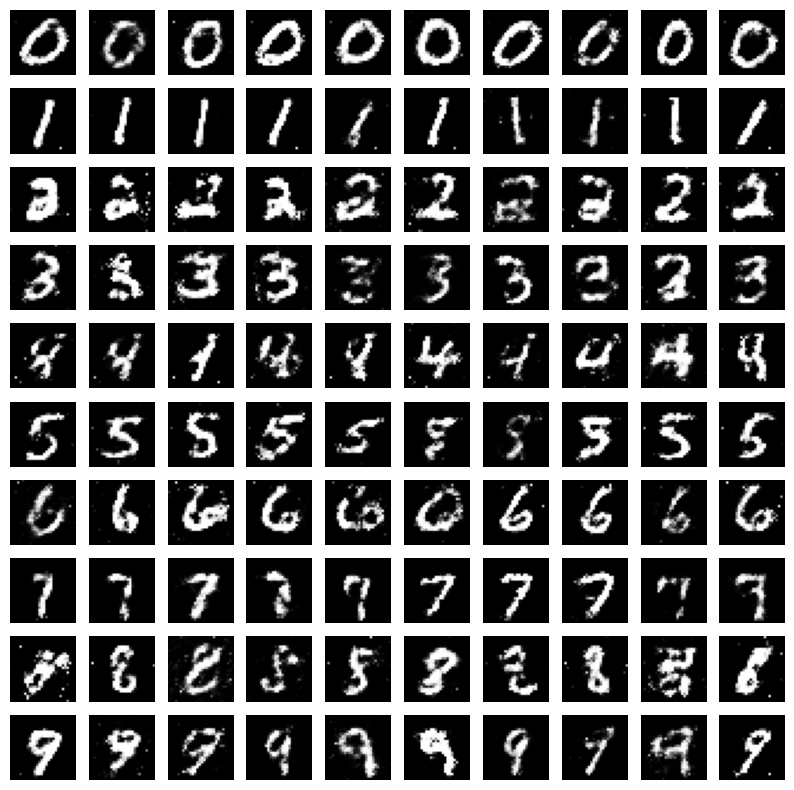

In [42]:
sample_num = 10
fig, axs = plt.subplots(class_num, sample_num, figsize=(sample_num, class_num))

for labels in range(class_num):
    for i in range(sample_num):
        z = get_noise(1, noise_dim)
        label_tensor = torch.tensor([labels], device=device)
        generated_image = generator(z, label_tensor).detach().cpu().view(28, 28)
        axs[labels, i].imshow(generated_image, cmap='gray')
        axs[labels, i].axis('off')

plt.show()
fig.savefig('mnist_cgan_results/sample_generated_images.png')
